In [1]:
import cv2
import toml
import sys
import os
import time
import json
import numpy as np
from IPython.display import display, Image, clear_output

import pynq

sys.path.append(os.path.abspath("data_management"))
sys.path.append(os.path.abspath("onnx_models"))
sys.path.append(os.path.abspath("hardware"))

import data_preprocessing as dprep
import data_postprocessing as dpostp
import onnx_inference as onnx_inf
import hw_partition as hw_part

%matplotlib inline
!sudo usermod -a -G video root

In [2]:
yolo_cfg = toml.load('yolov5n.toml')
inf_exec = yolo_cfg['inf_exec']
imgsz = yolo_cfg['input_data']['imgsz']
conf_thres = yolo_cfg['predictor']['conf_thres']
iou_thres = yolo_cfg['predictor']['iou_thres']
classes = yolo_cfg['predictor']['classes']
if not classes:
    classes = None
onnx_model_path = yolo_cfg['onnx_model_path']
if inf_exec == "fpga":
    onnx_model_path = f"{onnx_model_path.split('.onnx')[0]}_head.onnx"
visualize = yolo_cfg['visualize']
out_img_path = yolo_cfg['out_img_path']
input_source = yolo_cfg['source']
bitstream_path = yolo_cfg['hardware']['bitstream_path']
weights_lookup_table = yolo_cfg['hardware']['weights_lookup_table']
weights_path = yolo_cfg['hardware']['weights_path']
input_bp = yolo_cfg['hardware']['input_binary_point']
output_bp = yolo_cfg['hardware']['output_binary_point']
fifo_depth = yolo_cfg['hardware']['fifo_depth']

In [3]:
stride, names, session, output_names = onnx_inf.load_model(onnx_model_path)

In [4]:
#########################
### fpgaConvNet Setup ###
#########################

# initialise partition
partition = hw_part.Partition(bitstream_path, 5) 

# add input buffers
partition.add_input_buffer(0, 0, [320, 320, 3], bp=input_bp)

# add output buffers
partition.add_output_buffer(2, 2, [40, 40, 256], bp=output_bp, streams=2)
partition.add_output_buffer(3, 3, [20, 20, 256], bp=output_bp, streams=2)
partition.add_output_buffer(4, 4, [10, 10, 256], bp=output_bp, streams=2)

# create fifos
partition.add_fifo(0, 0, 2, 40*40*64 , burst=fifo_depth[0])
partition.add_fifo(1, 1, 1, 20*20*128, burst=fifo_depth[1])

# # setup hardware
partition.reset_hardware()

# get the lookup table for the weights
with open(weights_lookup_table, "r") as f:
    lookup = json.load(f)

# iterate over the weights
for layer, idx in lookup.items():

    # allocate weights and load them
    start_time = time.perf_counter() 
    partition.reload_weights(idx, f"{weights_path}/{layer}.dat")
    pred_time = (time.perf_counter() - start_time)*1000
    print(f"[{idx}] {layer} loaded! ({pred_time:.2f} ms)")

# setup hardware
partition.reset_hardware()
partition.start_hardware() 

[0] conv_0 loaded! (403.78 ms)
[1] conv_2 loaded! (1195.39 ms)
[2] conv_4 loaded! (18.79 ms)
[3] conv_11 loaded! (21.85 ms)
[4] conv_6 loaded! (20.98 ms)
[5] conv_8 loaded! (24.30 ms)
[6] conv_14 loaded! (19.63 ms)
[7] conv_16 loaded! (85.83 ms)
[8] conv_18 loaded! (23.41 ms)
[9] conv_30 loaded! (28.12 ms)
[10] conv_20 loaded! (23.76 ms)
[11] conv_22 loaded! (52.27 ms)
[12] conv_25 loaded! (19.69 ms)
[13] conv_27 loaded! (52.23 ms)
[14] conv_33 loaded! (31.53 ms)
[15] conv_35 loaded! (271.29 ms)
[16] conv_37 loaded! (49.85 ms)
[17] conv_54 loaded! (49.46 ms)
[18] conv_39 loaded! (34.90 ms)
[19] conv_41 loaded! (149.40 ms)
[20] conv_44 loaded! (128.81 ms)
[21] conv_46 loaded! (147.30 ms)
[22] conv_49 loaded! (35.04 ms)
[23] conv_51 loaded! (145.84 ms)
[24] conv_57 loaded! (80.16 ms)
[25] conv_59 loaded! (967.52 ms)
[26] conv_61 loaded! (131.19 ms)
[27] conv_68 loaded! (132.43 ms)
[28] conv_63 loaded! (77.47 ms)
[29] conv_65 loaded! (513.46 ms)
[30] conv_71 loaded! (242.85 ms)
[31] conv_

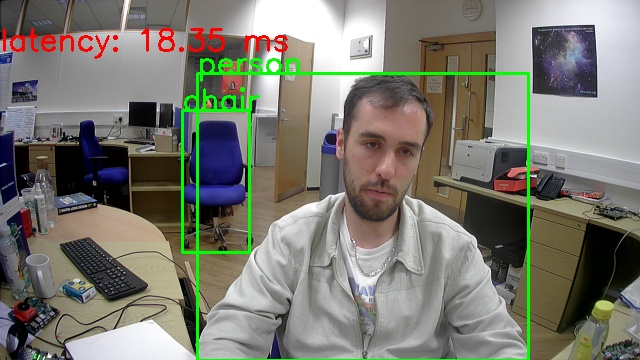

In [ ]:
if input_source == 'webcam':
    cap = cv2.VideoCapture(0) 
else:
    cap = cv2.VideoCapture(input_source)

# Capture frame-by-frame
ret, frame = cap.read()
    
frame_count = 0
try:
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Check that frame is not empty
        if ret:
            orig_img = frame.copy()

            start_time = time.perf_counter()
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = dprep.img_preprocess(img, imgsz, stride)
            preprocess_time = (time.perf_counter() - start_time) * 1000
            
            if inf_exec == "cpu":
                predictions, pred_time = onnx_inf.model_inf(img, session, output_names)
            elif inf_exec == "fpga":
                out0, out1, out2, pred_time = hw_part.run_fpgaconvnet(partition, img[0])
                predictions = session.run(output_names, {
                    "/model.24/m.0/Conv_output_0": np.expand_dims(out0[:255,:,:], axis=0),
                    "/model.24/m.1/Conv_output_0": np.expand_dims(out1[:255,:,:], axis=0),
                    "/model.24/m.2/Conv_output_0": np.expand_dims(out2[:255,:,:], axis=0),
                })[0]

            start_time = time.perf_counter()
            predictions = dpostp.yolo_nms(predictions, conf_thres, iou_thres, classes) 
            postprocess_time = (time.perf_counter() - start_time) * 1000

            visualize_time = 0
            for pred in predictions:
                
                start_time = time.perf_counter()
                pred[:, :4] = dpostp.scale_boxes((imgsz, imgsz), pred[:, :4], orig_img.shape).round()
                postprocess_time += (time.perf_counter() - start_time) * 1000
                
                start_time = time.perf_counter()
                for p in pred:

                    if visualize:
                        cv2.rectangle(orig_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (0, 255, 0), 2)
                        cv2.putText(orig_img, names[int(p[5])], (int(p[0]), int(p[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                visualize_time += (time.perf_counter() - start_time) * 1000

            start_time = time.perf_counter()
            if visualize:

                # add the time for inference
                cv2.putText(orig_img, f"latency: {pred_time:.2f} ms", (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
   
                _, disp_img = cv2.imencode('.jpg', orig_img)
                img_show = Image(data=disp_img)
                display(img_show)
                clear_output(wait=True)
                frame_count += 1
        else:
            break
except KeyboardInterrupt as e:
    print(e)
    cap.release()

In [ ]:
try:
    cap.release()
    cap.destroyAllWindows()
except Exception as e:
    print(e)
    pass